In [1]:
import pandas as pd
import pickle

import cntext as ct

# 读取旧版pkl文件
data = ct.load_pkl_dict('ChineseEmoBank.pkl')

# 立即转换为跨版本格式（推荐csv或parquet）
data.to_csv('concreteness.csv', index=False)

AttributeError: 'dict' object has no attribute 'to_csv'

In [3]:
data['ChineseEmoBank']

,word,valence,arousal
0,不可思议,5.4,7.2
1,不平,3.6,5.8
2,不甘,3.2,6.4
3,不安,3.8,5.4
4,不利,3.6,5.6
...,...,...,...
5505,黏闷,2.8,5.6
5506,黏腻,2.7,5.8
5507,艳丽,5.8,4.5
5508,苗条,6.7,3.8


In [5]:
imp_path = "impro_content.txt"
orig_path = "orig_content.txt"

textimp = open(imp_path, 'r', encoding='utf-8').read()
textorig = open(orig_path, 'r', encoding='utf-8').read()
map = {'改善文本':textimp, 'basemodel 文本':textorig}
# print(ct.load_pkl_dict('ChineseEmoBank.pkl'))
concreteness_df = ct.load_pkl_dict('concreteness.pkl')
for k,text in map.items():
    print(k)
    ret = ct.sentiment_by_weight(text, data['ChineseEmoBank'],  ['valence', 'arousal'],
                        lang = 'chinese')
    print(ret)
    Valence = ret['valence']/ret['word_num']

    Arousal = ret['arousal']/ret['word_num']
    print('Valence:',Valence,' Arousal:',Arousal)

改善文本
{'valence': 117.6, 'arousal': 98.6, 'word_num': 249}
Valence: 0.472289156626506  Arousal: 0.39598393574297186
basemodel 文本
{'valence': 87.9, 'arousal': 84.1, 'word_num': 150}
Valence: 0.5860000000000001  Arousal: 0.5606666666666666


{'3 hot contents': array([-21.46922803,  -8.50661626, -13.964687  ,  -6.45884271]), 'RAG+1hot content': array([ 31.0565635 ,   9.07372401, -23.14963439, -12.61206194]), 'RAG+3hot contents': array([  9.60512273,   5.86011342, -31.56768325,  11.04319478])}


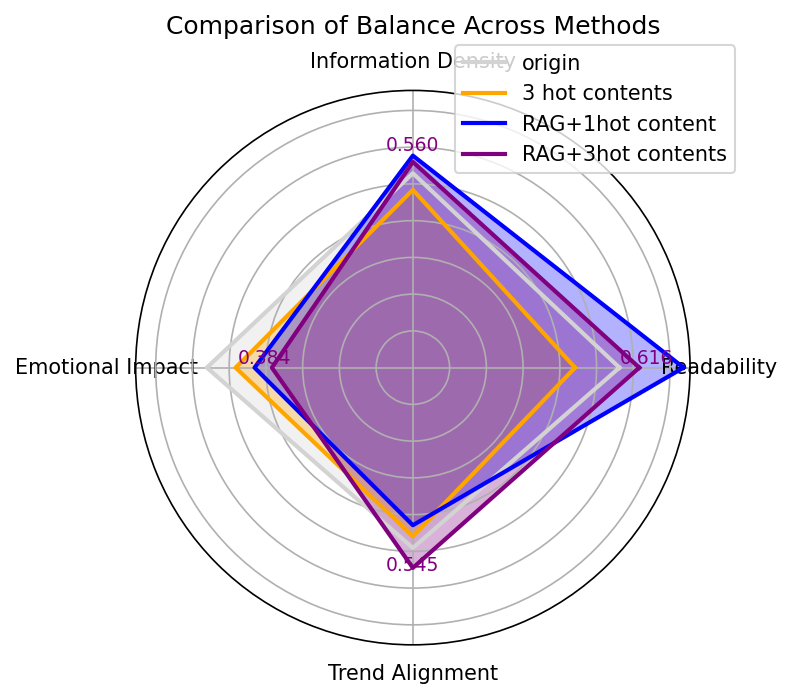

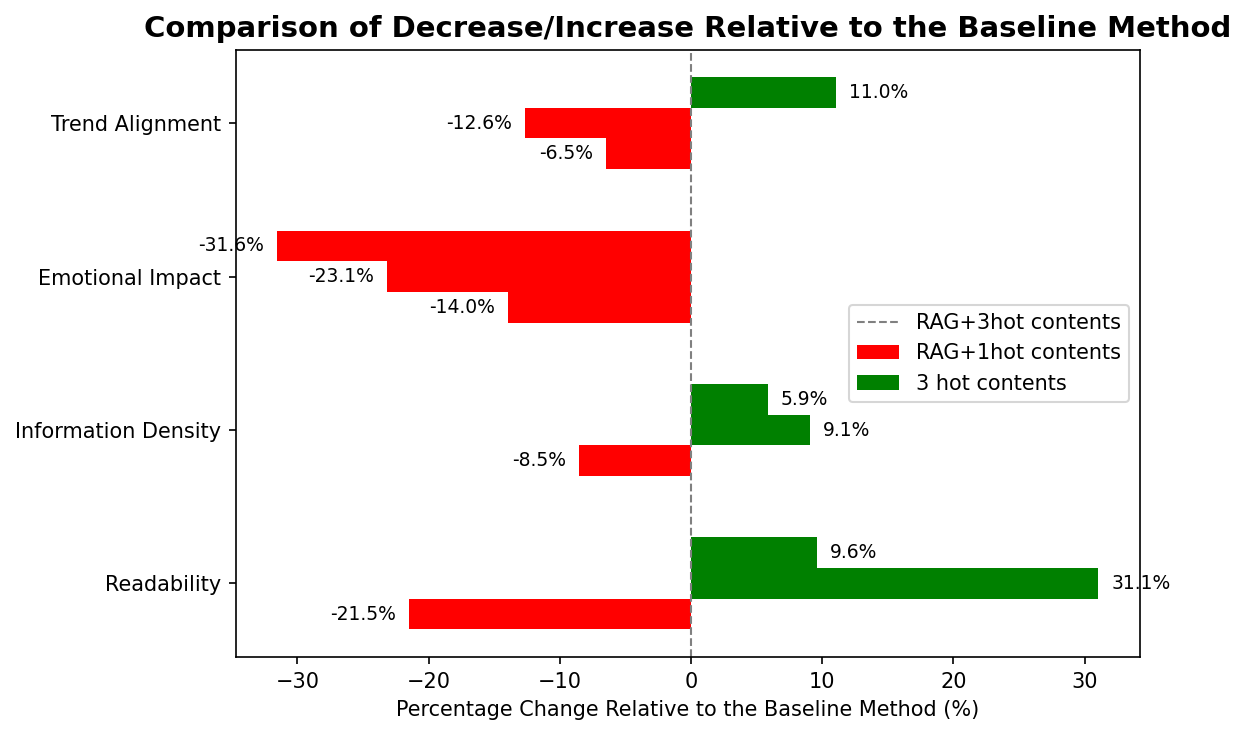

In [8]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
from matplotlib.colors import LinearSegmentedColormap
plt.rcParams.update({'figure.dpi':150})

# 数据
methods = {
    'origin': [0.5622, 0.5290, 0.5607, 0.4908],
    '3 hot contents': [0.4415, 0.4840, 0.4824, 0.4591],
    'RAG+1hot content': [0.7368, 0.5770, 0.4309, 0.4289],
    'RAG+3hot contents': [0.6162, 0.5600, 0.3837, 0.5450],
}
metrics = ['Readability', 'Information Density', 'Emotional Impact', 'Trend Alignment']

# 1. 雷达图
angles = np.linspace(0, 2 * np.pi, len(metrics), endpoint=False).tolist()
angles += angles[:1]  # 闭合

fig1, ax1 = plt.subplots(subplot_kw={'projection': 'polar'})
colors = ['lightgray', 'orange', 'blue', 'purple']
for idx, (method, values) in enumerate(methods.items()):
    vals = values + values[:1]
    ax1.plot(angles, vals, color=colors[idx], linewidth=2, label=method)
    ax1.fill(angles, vals, color=colors[idx], alpha=0.3)

# 标注 RAG+3 顶点数值
rag3_vals = methods['RAG+3hot contents']
for angle, val in zip(angles[:-1], rag3_vals):
    ax1.text(angle, val + 0.02, f"{val:.3f}", color='purple', fontsize=9, ha='center', va='bottom')

# 设置
ax1.set_xticks(angles[:-1])
ax1.set_xticklabels(metrics)
ax1.set_yticklabels([])
ax1.set_title("Comparison of Balance Across Methods", va='bottom')
ax1.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))
#plt.tight_layout()
# plt.show()

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# 数据
baseline = np.array([0.5622, 0.5290, 0.5607, 0.4908])  # 原始方法得分
methods = {
    '3 hot contents': np.array([0.4415, 0.4840, 0.4824, 0.4591]),
    'RAG+1hot content': np.array([0.7368, 0.5770, 0.4309, 0.4289]),
    'RAG+3hot contents': np.array([0.6162, 0.5600, 0.3837, 0.5450]),
}
metrics = ['Readability', 'Information Density', 'Emotional Impact', 'Trend Alignment']

# 计算相对于基线的百分比变化
changes = {method: (scores - baseline) / baseline * 100 for method, scores in methods.items()}

# 转为 DataFrame
df = pd.DataFrame(changes, index=metrics)
print(changes)
# 绘制发散型条形图
fig, ax = plt.subplots(figsize=(8, 5))
y = np.arange(len(metrics))
bar_width = 0.2
offsets = np.linspace(-bar_width, bar_width, len(methods))

for (method, offset), color in zip(zip(changes.items(), offsets), ['red', 'blue', 'purple']):
    name, vals = method
    ax.barh(y + offset, vals, height=bar_width, 
            color=np.where(vals >= 0, 'green', 'red'))  # 正负不同颜色 label=name

# 绘制基线（零线）
ax.axvline(0, color='gray', linestyle='--', linewidth=1)

# 添加数值标签
for i, metric in enumerate(metrics):
    for j, method in enumerate(changes):
        val = df.loc[metric, method]
        ax.text(val + (1 if val >= 0 else -1), i + offsets[j],
                f"{val:.1f}%", va='center',
                ha='left' if val >= 0 else 'right', fontsize=9)

# 设置
ax.set_yticks(y)
ax.set_yticklabels(metrics)
ax.set_xlabel('Percentage Change Relative to the Baseline Method (%)')
ax.set_title('Comparison of Decrease/Increase Relative to the Baseline Method',fontsize=14, fontweight='bold')
ax.legend(['RAG+3hot contents', 'RAG+1hot contents', '3 hot contents'], )
plt.tight_layout()
plt.show()





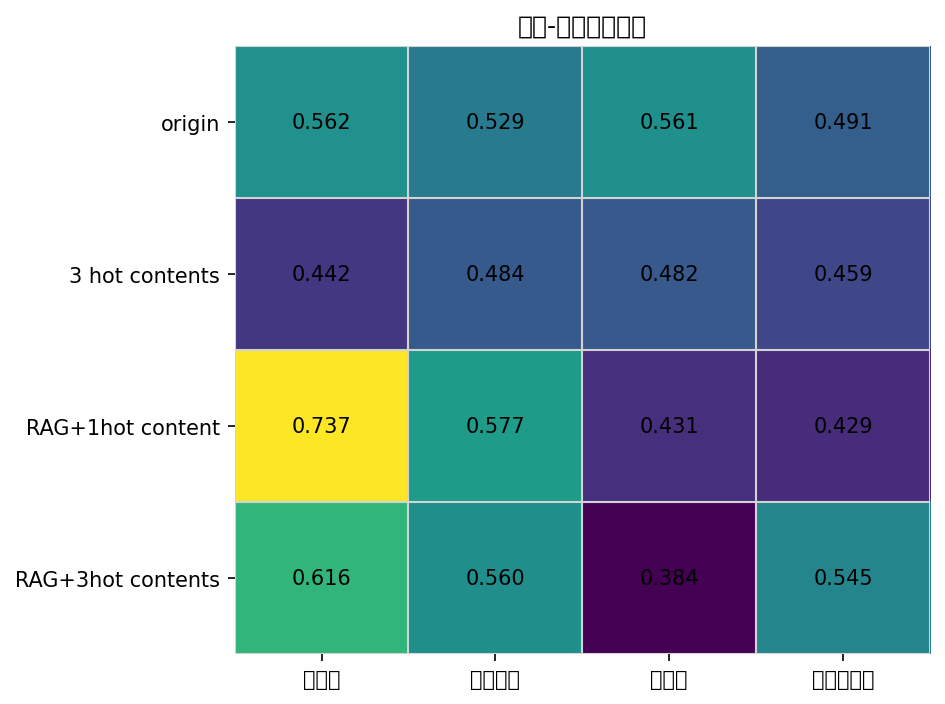

In [11]:
# 2. 热力矩阵
df = pd.DataFrame(methods, index=metrics).T

# 自定义从深蓝到亮黄的 colormap
# cmap = LinearSegmentedColormap.from_list('blue_yellow', ['#00008B', '#FFFF00'])

fig2, ax2 = plt.subplots()
cax = ax2.imshow(df.values, cmap='viridis', aspect='auto')

# 设置刻度
ax2.set_xticks(np.arange(len(metrics)))
ax2.set_yticks(np.arange(len(df.index)))
ax2.set_xticklabels(metrics)
ax2.set_yticklabels(df.index)

# 显示数值并添加浅灰色框线
for i in range(df.shape[0]):
    for j in range(df.shape[1]):
        ax2.text(j, i, f"{df.values[i, j]:.3f}", ha='center', va='center', color='black')

ax2.set_title("方法-指标热力矩阵")
for edge, spine in ax2.spines.items():
    spine.set_visible(False)
ax2.set_xticks(np.arange(-.5, len(metrics), 1), minor=True)
ax2.set_yticks(np.arange(-.5, len(df.index), 1), minor=True)
ax2.grid(which='minor', color='lightgray', linestyle='-', linewidth=1)
ax2.tick_params(which="minor", bottom=False, left=False)
plt.tight_layout()
plt.show()